In [1]:
import os
hf_token = os.environ['HF_TOKEN']

In [2]:
from huggingface_hub import login

login(hf_token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
import torch
import transformers

model_id = "google/gemma-3-4b-it"
model_path = "./gemma-product-description"

In [4]:
from datasets import load_dataset

DATASET_BASE = "/home/junhee0110/dataset/images_split_{}" #"/home/iamjunhee/OhMyData/SpatialQA/dataset/images_split_{}"
JSON_BASE = "NewQA_split_{}.json"
SPLIT_NUMBER = 1


get_dataset_dir = lambda index: DATASET_BASE.format(index)
get_json_dir = lambda index: os.path.join(DATASET_BASE.format(index), JSON_BASE.format(index))

dataset = load_dataset("json", data_files=get_json_dir(SPLIT_NUMBER), split="train")

In [5]:
dataset[0]["image"]

['visual_genome/3638.jpg', 'visual_genome_d/3638.png']

In [6]:
from PIL import Image
import numpy as np

image_path = lambda index, data, d: os.path.join(get_dataset_dir(SPLIT_NUMBER), data[index]["image"][d])

def load_and_process_image(path: str) -> str:
    image = Image.open(path)
    channels = len(image.getbands())
    
    if channels == 1:
        img = np.array(image)
        height, width = img.shape
        three_channel_array = np.zeros((height, width, 3), dtype=np.uint8)
    
        if img.dtype == np.uint8:
            img = img.astype(np.uint16)
            img = ((img / 255) * 65535).astype(np.uint16)
        
        three_channel_array[:, :, 0] = (img // 1024) * 2
        three_channel_array[:, :, 1] = (img // 32) * 8
        three_channel_array[:, :, 2] = (img % 32) * 8
        image = Image.fromarray(three_channel_array, "RGB")
    
    return image

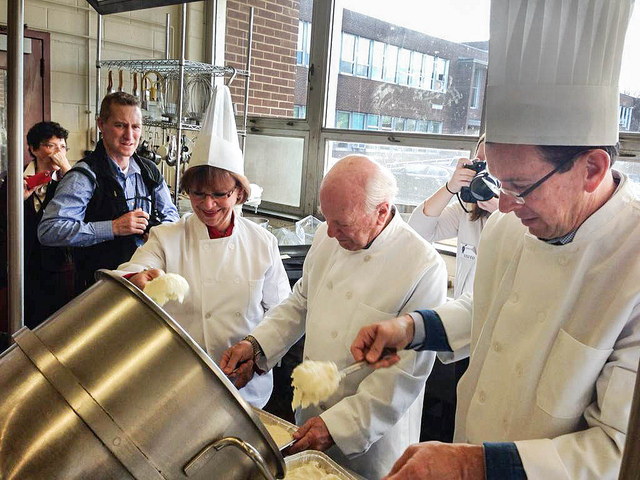

In [66]:
load_and_process_image(image_path(2525, dataset, 0))

In [8]:
from peft import PeftModel
from transformers import AutoProcessor, AutoModelForImageTextToText

model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2"
)

perf_model = PeftModel.from_pretrained(model, model_path)
processor = AutoProcessor.from_pretrained(model_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/junhee0110/.agricsense/lib/python3.10/site-packages/peft/tuners/tuners_utils.py:550: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['language_model.lm_head'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(


In [73]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": load_and_process_image(image_path(2525, dataset, 0))},
            {"type": "image", "image": load_and_process_image(image_path(2525, dataset, 1))},
            {"type": "text", "text": "Describe the detph of the chef on the right"}
        ]
    }
]

In [74]:
inputs = processor.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=True,
    return_dict=True, return_tensors="pt"
).to(model.device, dtype=torch.bfloat16)

input_len = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=200, do_sample=False)
    generation = generation[0][input_len:]

decoded = processor.decode(generation, skip_special_tokens=True)
print(decoded)

The chef on the right has a depth value of 1131.
